In [36]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from scipy.spatial.distance import jensenshannon

In [37]:
print('Date ranges available:')
for file in glob.glob('input/imputed/*.csv'):
    date_start = file.split('/')[-1].split('.')[0].split('_')[-3]
    date_end = file.split('/')[-1].split('.')[0].split('_')[-1]
    print(f"{date_start}_to_{date_end}")

Date ranges available:
2000_to_2020


In [38]:
date_range_selection = '2000_to_2020'
num_features_to_validate = 5

In [39]:
df_imputed = pd.read_csv(f'input/imputed/df_wide_knn_imputed_{date_range_selection}.csv')
df_original = pd.read_csv(f'input/transformed/df_wide_{date_range_selection}.csv')
df_original_filtered = df_original[list(df_imputed.columns)]

In [40]:
missing_data_cols = {}

for col in df_original_filtered.columns:
    if df_original_filtered[col].isnull().any():
        missing_data_cols[col] = df_original_filtered[col].isnull().sum() / df_original_filtered[col].shape[0]
        
# Convert the dictionary to a DataFrame with one row and columns for each feature
missing_data_df = pd.DataFrame([missing_data_cols]).T.reset_index()
missing_data_df.columns = ['Feature', 'Missing Percentage']

# Sort by missing percentage in descending order
missing_data_df = missing_data_df.sort_values('Missing Percentage', ascending=False)

# Display the top features with missing data
display(missing_data_df.head(num_features_to_validate))
features_to_validate = missing_data_df.head(num_features_to_validate)['Feature'].tolist()
# tail_features = missing_data_df.tail(num_features_to_validate)['Feature'].tolist()

,Feature,Missing Percentage
286,SE.SEC.CUAT.PO.MA.ZS,0.796604
35,DC.DAC.SVKL.CD,0.792830
270,SE.PRE.TCAQ.MA.ZS,0.783962
189,MS.MIL.XPRT.KD,0.770943
185,LP.LPI.ITRN.XQ,0.769623


In [41]:
def plot_distribution_comparison(feature, df_imputed, df_original_filtered):
    """Make a density plot comparing imputed vs original values with stats."""
    
    imputed_values = df_imputed[feature].dropna()
    original_values = df_original_filtered[feature].dropna()
    
    # Create plot
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.kdeplot(imputed_values, label='Imputed Values', fill=True, alpha=0.5, ax=ax)
    sns.kdeplot(original_values, label='Original Values', fill=True, alpha=0.5, ax=ax)
    
    ax.set_title(f'Distribution Comparison: {feature}', fontsize=14)
    ax.set_xlabel('Value', fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.legend(fontsize=10)
    
    # Add stats to plot
    stats_text = []
    stats_text.append(f'Imputed: mean={imputed_values.mean():.3f}, std={imputed_values.std():.3f}, n={len(imputed_values)}')
    stats_text.append(f'Original: mean={original_values.mean():.3f}, std={original_values.std():.3f}, n={len(original_values)}')
    
    # KS test
    ks_stat, ks_pval = stats.ks_2samp(imputed_values, original_values)
    stats_text.append(f'KS test: stat={ks_stat:.3f}, p={ks_pval:.3g} {"(Similar)" if ks_pval > 0.05 else "(Different)"}')
    
    # Calculate overlap
    try:
        bins = np.linspace(min(imputed_values.min(), original_values.min()), 
                           max(imputed_values.max(), original_values.max()), 100)
        
        hist_imputed, _ = np.histogram(imputed_values, bins=bins, density=True)
        hist_original, _ = np.histogram(original_values, bins=bins, density=True)
        
        hist_imputed = hist_imputed / np.sum(hist_imputed)
        hist_original = hist_original / np.sum(hist_original)
        
        hist_imputed = np.maximum(hist_imputed, 1e-10)
        hist_original = np.maximum(hist_original, 1e-10)
        
        js_div = jensenshannon(hist_imputed, hist_original)
        stats_text.append(f'JS divergence: {js_div:.3f}')
        
        overlap = np.sum(np.minimum(hist_imputed, hist_original))
        stats_text.append(f'Distribution overlap: {overlap:.3f}')
    except:
        pass
    
    # Add stats box
    props = dict(boxstyle='round', facecolor='white', alpha=0.7)
    ax.text(0.02, 0.98, '\n'.join(stats_text), transform=ax.transAxes, 
            fontsize=9, verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plt.show()
    print()

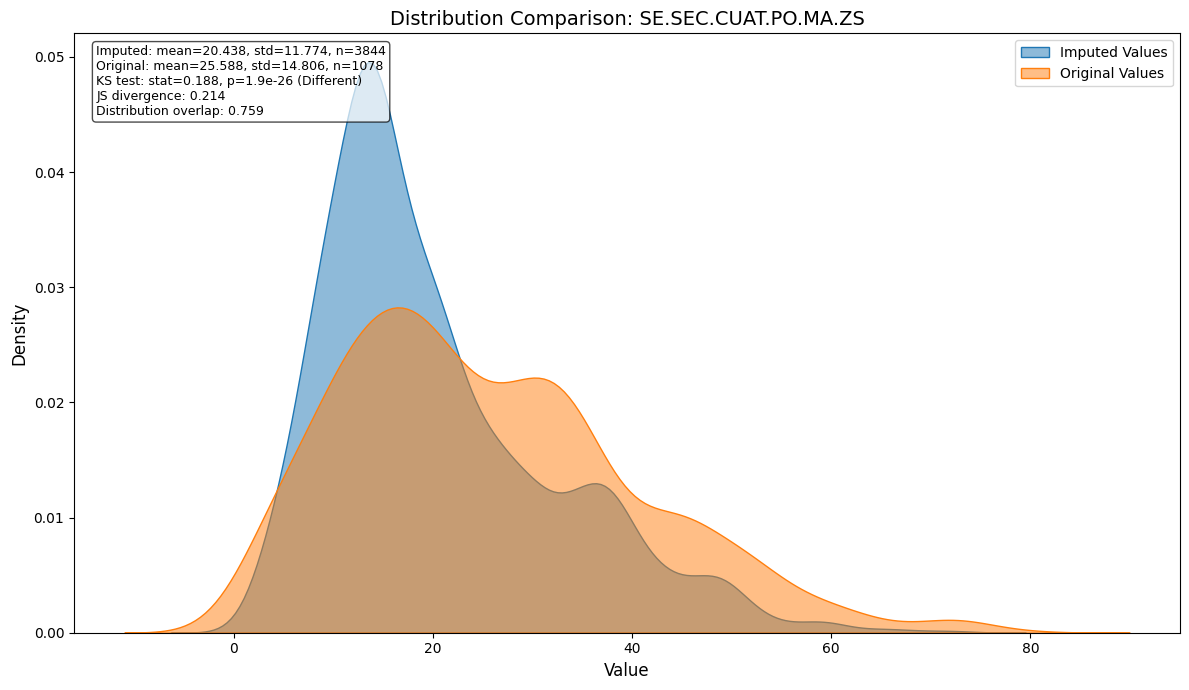

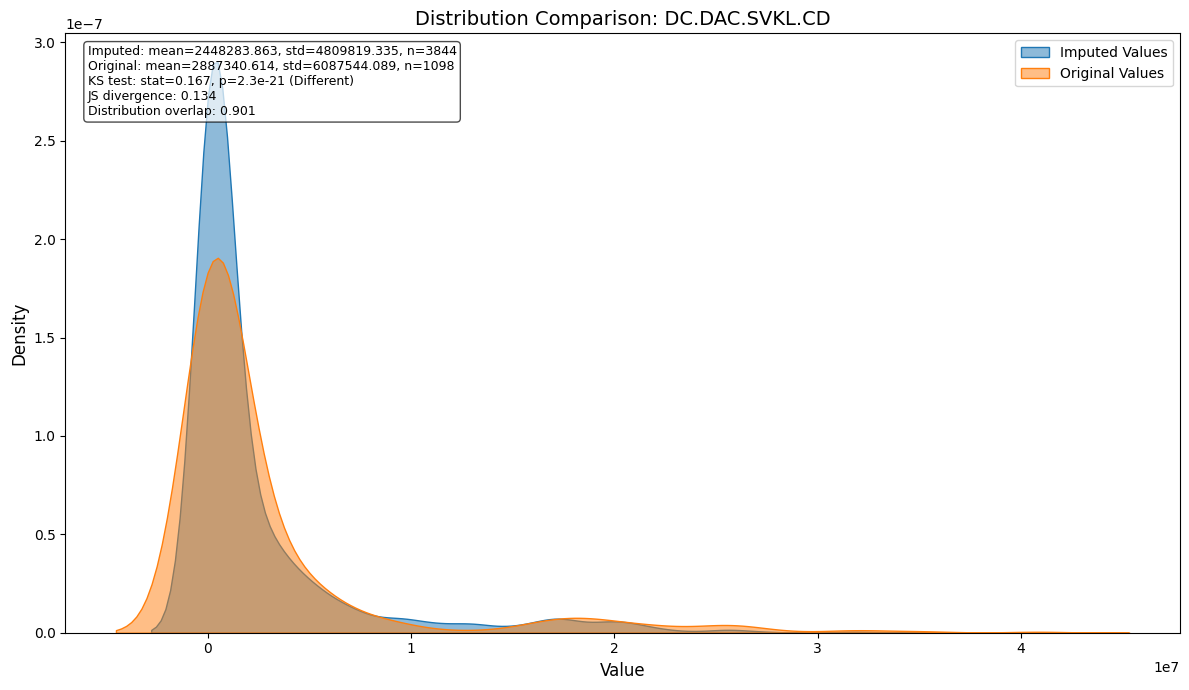

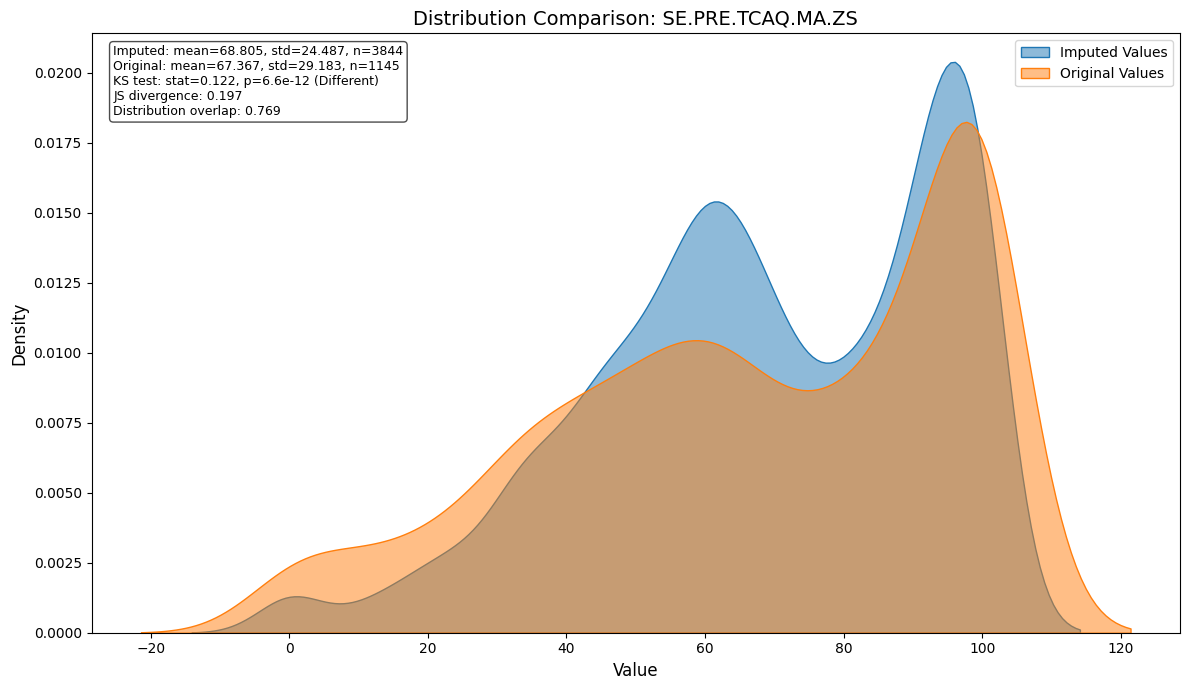

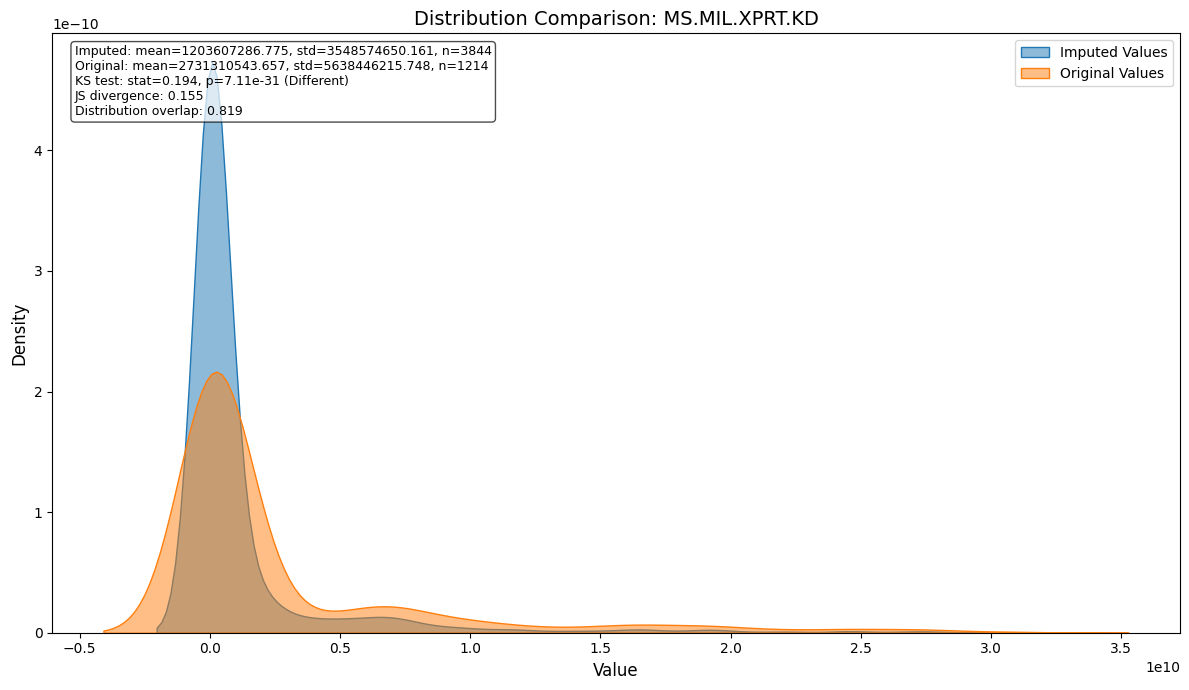

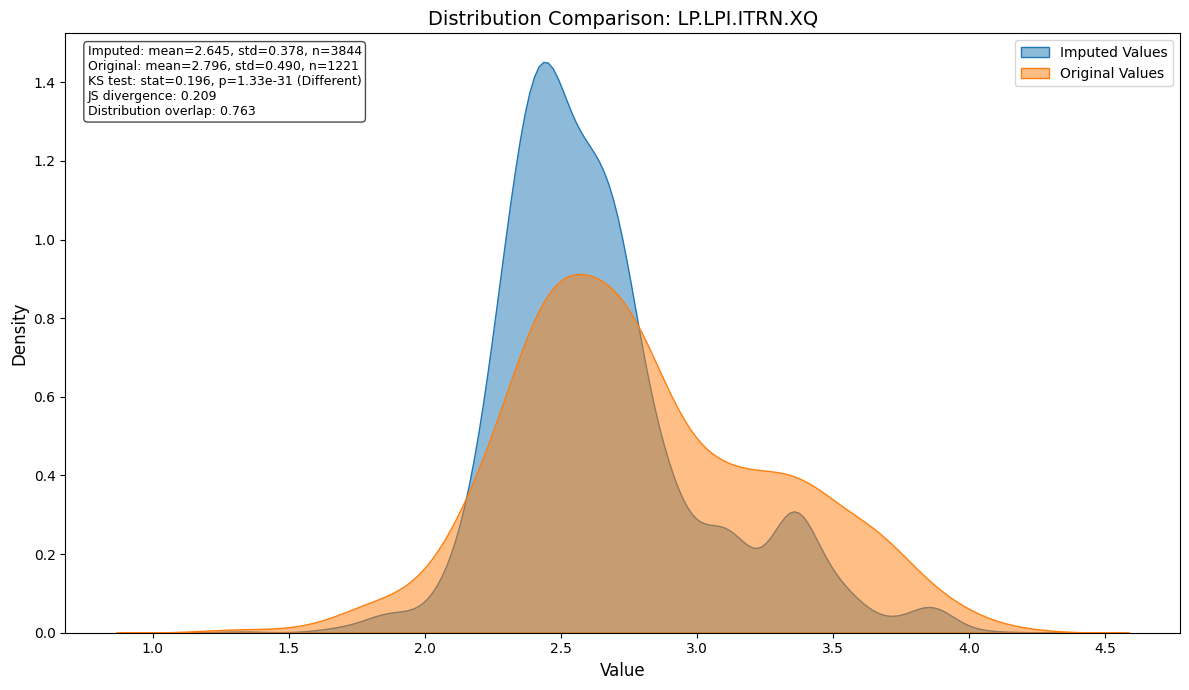

In [42]:
for feature in features_to_validate:
    plot_distribution_comparison(feature, df_imputed, df_original_filtered)

In [43]:
# these fits should be really good
# for feature in tail_features:
#     plot_distribution_comparison(feature, df_imputed, df_original_filtered)